In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import numpy as np
import matplotlib.pyplot as plt
fig_width = 12
%matplotlib inline

In [2]:
import bayesianchangepoint as bcp


## performing inference: application to experimental data


get your trump data:

https://github.com/bpb27/trump_tweet_data_archive

In [3]:
from io import BytesIO
from zipfile import ZipFile
import urllib.request
import json

datafile = 'trumpets.json'
datafile = '/tmp/trumpets.json'

try:
    with open(datafile, 'r') as f:
        data = json.load(f)
except:
    years = [8] #[2, 3, 4, 5, 6, 7]
    years = [6, 7]
    years = [2, 3, 4, 5, 6, 7, 8]
    years = [5, 6, 7, 8]



    data = []
    arctype = 'condensed'
    arctype = 'master'
    for year in years:
        url = urllib.request.urlopen("https://github.com/bpb27/trump_tweet_data_archive/blob/master/{arctype}_201{Y}.json.zip?raw=true".format(arctype=arctype, Y=str(year)))
        print('Downloading ', url, '...')
        with ZipFile(BytesIO(url.read())) as my_zip_file:
            for contained_file in my_zip_file.namelist():
                with my_zip_file.open(contained_file) as f:
                    #data.extend(json.load(f))
                    data.extend(json.loads(f.read().decode('utf-8')))
    with open(datafile, 'w') as f:
        json.dump(data, f)          

In [4]:
!ls -ltr /tmp/*json

-rw-r--r--  1 lolo  wheel  55702757 Apr  4 16:18 /tmp/trumpets.json


In [5]:
n_tweets = len(data)
print('number ow tweets=', n_tweets)

number ow tweets= 16971


## example tweet

In [6]:
i_sample = 42
i_sample = 1973
d = data[i_sample]
d#.keys()#['followers_count']

{'contributors': None,
 'coordinates': None,
 'created_at': 'Tue Sep 29 03:51:52 +0000 2015',
 'entities': {'hashtags': [],
  'symbols': [],
  'urls': [],
  'user_mentions': [{'id': 18281493,
    'id_str': '18281493',
    'indices': [1, 9],
    'name': 'polina6',
    'screen_name': 'polina6'},
   {'id': 25073877,
    'id_str': '25073877',
    'indices': [11, 27],
    'name': 'Donald J. Trump',
    'screen_name': 'realDonaldTrump'}]},
 'favorite_count': 3251,
 'favorited': False,
 'geo': None,
 'id': 648706734270382080,
 'id_str': '648706734270382080',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'place': None,
 'retweet_count': 1306,
 'retweeted': False,
 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
 'text': '"@polina6: @realDonaldTrump MAN WITH A PLAN-THE BEST TAX PLAN! G

Removing tweets from staff (see http://varianceexplained.org/r/trump-tweets/)

In [7]:
'iPhone' in data[i_sample]['source']

False

In [8]:
data_cleanup = []
for tweet in data:
    if not 'iPhone' in tweet['source']:
        data_cleanup.append(tweet)
print('we had', len(data), 'tweets')
print('we now have', len(data_cleanup), 'tweets')
data = data_cleanup
n_tweets = len(data)



we had 16971 tweets
we now have 10390 tweets


In [9]:
data[i_sample]['source']

'<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>'

## learning to handle datetimes

https://docs.python.org/3/library/datetime.html


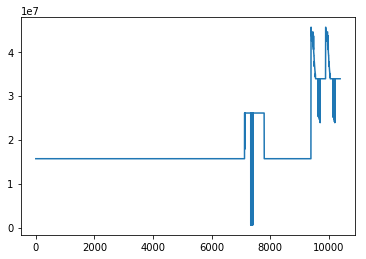

In [10]:
followers = [data[i]['user']['followers_count'] for i in range(n_tweets)]
plt.plot(followers);

In [11]:
data_texts = []
for i_tweet in range(n_tweets):
    try:
        data_texts.append(data[i_sample]['full_text'].lower())
    except KeyError:
        data_texts.append(data[i_sample]['text'].lower())

data_texts[i_sample]

'"@lettyntx: obama left our american hostages in iran. #trump2016 @realdonaldtrump" sadly, so true!'

In [12]:
word = 'america'
word = '?'
contains_word = np.array([(word in data_text) for data_text in data_texts])
print(sum(contains_word), 'tweets contain the word "', word, '" on a total of ', n_tweets, 'tweets')

0 tweets contain the word " ? " on a total of  10390 tweets


In [13]:
datetimes = [data[i]['created_at'] for i in range(n_tweets)]
print('|'+datetimes[0]+'|')

|Thu Dec 31 23:21:49 +0000 2015|


In [14]:
import locale
locale.getlocale()

('en_US', 'UTF-8')

In [15]:
from datetime import datetime

datetimes = [datetime.strptime(data[i]['created_at'], '%a %b %d %H:%M:%S %z %Y') for i in range(n_tweets)]
print('Timestamp=', datetimes[0].timestamp())

Timestamp= 1451604109.0


In [16]:
from datetime import datetime

datetimes = np.array([datetime.strptime(data[i]['created_at'], '%a %b %d %H:%M:%S %z %Y').timestamp() for i in range(n_tweets)])
print('Timestamp=', (datetimes[0]))

Timestamp= 1451604109.0


In [17]:
from datetime import datetime

datetimes = [datetime.strptime(data[i]['created_at'], '%a %b %d %H:%M:%S %z %Y') for i in range(n_tweets)]
print('Timestamp=', datetimes[0].timestamp())

Timestamp= 1451604109.0


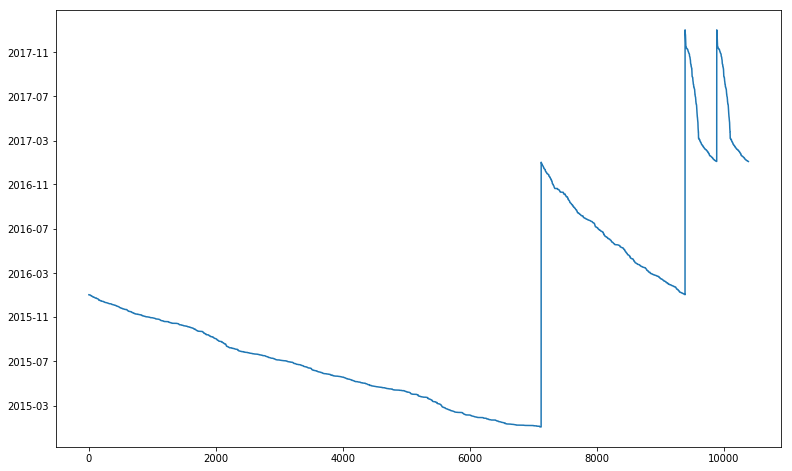

In [18]:
fig_width = 13
fig, ax = plt.subplots(figsize=(fig_width, fig_width/1.6180))
ax.plot(datetimes);

It seems that within each year, tweets are in inverse chronological order. 
Let's sort things:

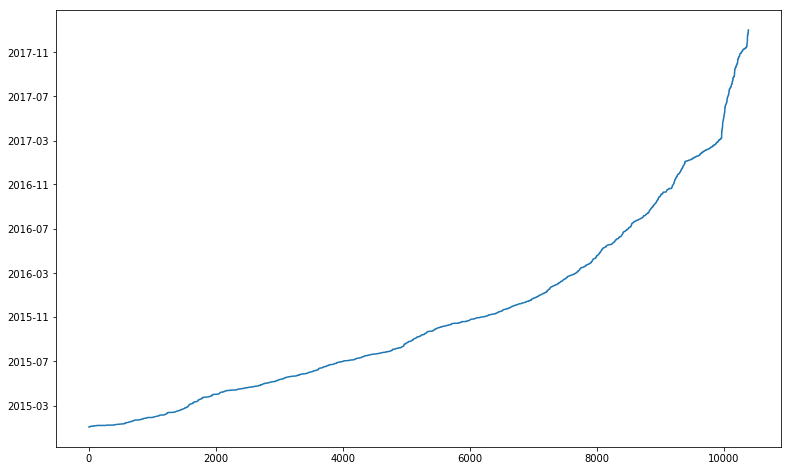

In [19]:
datetimes = np.array(datetimes)
ind_tweets = np.argsort(datetimes)

fig, ax = plt.subplots(figsize=(fig_width, fig_width/1.6180))
ax.plot(datetimes[ind_tweets]);

We will be using https://matplotlib.org/examples/api/date_demo.html

## evolution of followers

In [20]:
import datetime
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

monthsFmt = mdates.DateFormatter('%Y-%m')



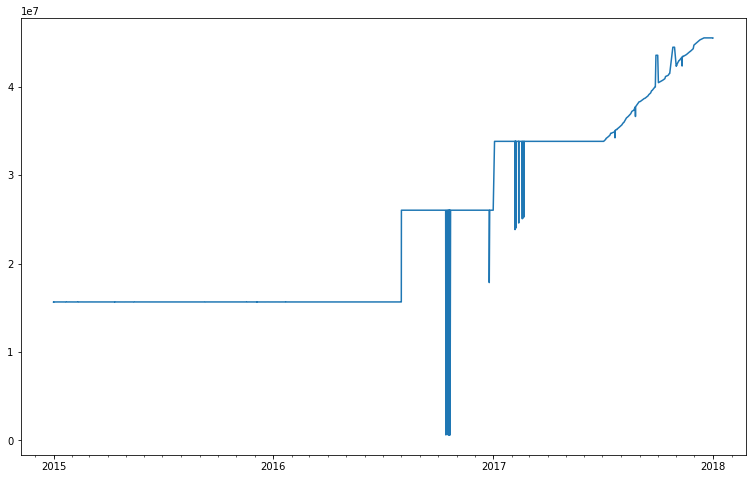

In [21]:
followers = np.array([data[i]['user']['followers_count'] for i in range(n_tweets)])

fig_width = 13
fig, ax = plt.subplots(figsize=(fig_width, fig_width/1.6180))
ax.plot(datetimes[ind_tweets], followers[ind_tweets])
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d');

In [22]:
i= 42
data_texts = []
for i in range(n_tweets):
    try:
        data_texts.append(data[i]['full_text'].lower())
    except KeyError:
        data_texts.append(data[i]['text'].lower())

data_texts[i]

'well, the new year begins. we will, together, make america great again!'

In [23]:
word = 'america'
contains_word = np.array([(word in data_text) for data_text in data_texts])
print(sum(contains_word), 'tweets contain the word "', word, '" on a total of ', n_tweets, 'tweets')
p0 = sum(contains_word) / n_tweets
print('That is, an average probability of p0= ', p0)

1242 tweets contain the word " america " on a total of  10390 tweets
That is, an average probability of p0=  0.11953801732435033


## detecting change points



In [24]:
h = 1/1500
max_run_length = int(6/h)
p0 = sum(contains_word) / n_tweets

In [25]:
p_bar, r, beliefs = bcp.inference(contains_word[ind_tweets], h=h, p0=p0)

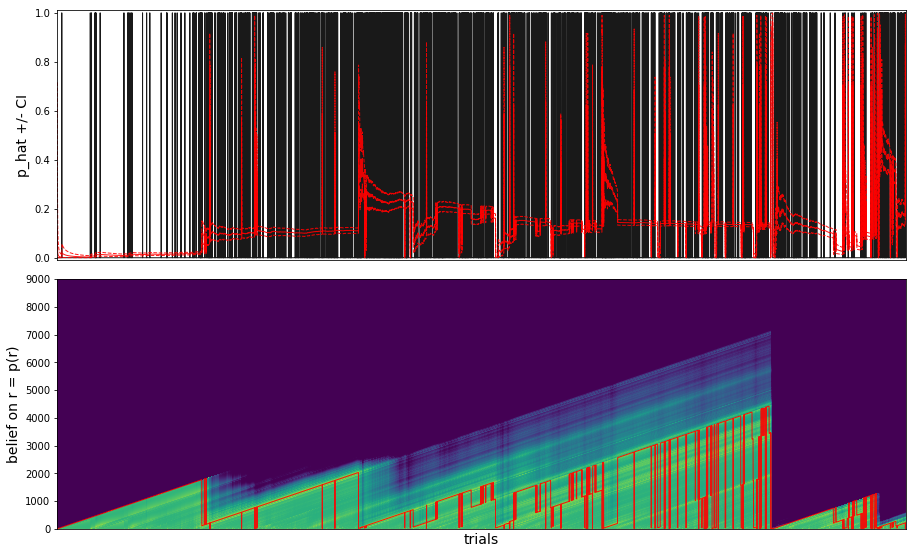

In [26]:
fig, axs = bcp.plot_inference(contains_word[ind_tweets], None, p_bar, r, beliefs, mode='max', max_run_length=max_run_length)
ax = axs[-1]
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

## wraping things up

In [27]:
!ls -ltr -fr /tmp/data_cache

ls: /tmp/data_cache: No such file or directory


mode fixed


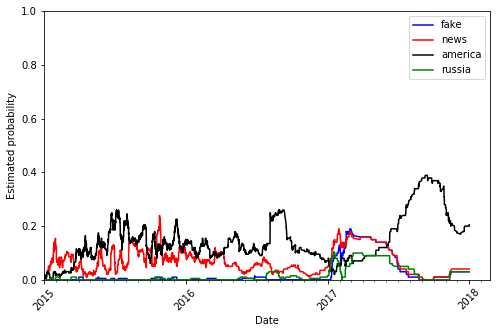

mode hindsight
-0.2563286215045145 0.21991945534414248


ValueError: NumPy boolean array indexing assignment cannot assign 10390 input values to the 4 output values where the mask is true

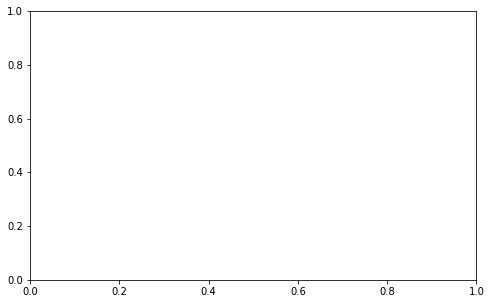

In [35]:
def analyze(words, mode_, fig_width=8):
    
    
    
    fixed_window_size = 200


    fig, ax = plt.subplots(figsize=(fig_width, fig_width/1.6180))


    print ('mode', mode_)
    for word, c in zip(words, ['b', 'r', 'k', 'g']): #'?', '!', 

        filename = "/tmp/data_cache/" + word + ".npz"
        try:
            npzfile = np.load(filename)
            p_bar, r_bar, beliefs = npzfile['p_bar'], npzfile['r_bar'], npzfile['beliefs'] 
            #hack # to recompute files 
        except Exception as e:
            print('Computing for word' , word, ' - ', e)
            try:
                import os
                os.mkdir('/tmp/data_cache')
            except:
                pass

            contains_word = np.array([(word in data_text) for data_text in data_texts])
            p0 = sum(contains_word) / n_tweets

            p_bar, r_bar, beliefs = bcp.inference(contains_word[ind_tweets], h=h, p0=p0)#, max_T=max_run_length)

            np.savez(filename, p_bar=p_bar, r_bar=r_bar, beliefs=beliefs)

        if mode_=='fixed': 
            p_hat, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode=mode_, fixed_window_size=fixed_window_size)
        else:
            p_hat, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode=mode_)

        if mode_=='hindsight':
            print (np.gradient(p_hat).min(), np.gradient(p_hat).max())
            highgrad = np.abs(np.gradient(p_hat)) > .2
            p_hat[highgrad] = p_hat[highgrad+1]

        ax.plot(datetimes[ind_tweets], p_hat, c=c, label=word)
        #ax.plot(datetimes)


    #datemin = datetime.date(datetimes.min(), 1, 1)
    #datemax = datetime.date(datetimes.max() + 1, 1, 1)
    #ax.set_xlim(datemin, datemax)
    if True:
        ax.xaxis.set_major_locator(years)
        ax.xaxis.set_major_formatter(yearsFmt)
        ax.xaxis.set_minor_locator(months)
    else:
        ax.xaxis.set_major_locator(months)
        ax.xaxis.set_major_formatter(monthsFmt)
    #ax.xaxis.set_minor_locator(months)
    #ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    #ax.set_yscale('log')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

    ax.set_xlabel('Date')
    ax.set_ylabel('Estimated probability')    
    ax.legend(loc='best')
    #ax.set_xlim(datetime.datetime(2015, 6, 15, 12, 21, 4, tzinfo=datetime.timezone.utc), datetime.datetime(2017, 12, 31, 18, 59, 4, tzinfo=datetime.timezone.utc))

    ax.set_xlim(datetime.datetime(2015, 1, 1, 12, 21, 4, tzinfo=datetime.timezone.utc))
    ax.set_ylim(0, 1)


    return fig, ax

modes = ['fixed', 'expectation', 'max', 'hindsight', ]
modes = ['fixed', 'hindsight', ]


for words in [['fake', 'news', 'america', 'russia'], 
              #['obama', 'hillary', 'putin', 'pence'],
              #['golf', 'crazy', 'weak', 'joke'],
              #['obama', 'hillary', 'crooked', 'CNN'],
              #['covfefe', 'counsel', 'crooked', 'lightweight'],
              #['great', 'amazing', 'bad', 'sad'],
             ]:
    for i_mode, mode_ in enumerate(modes):
        fig, ax = analyze(words, mode_)
        plt.show()
        import os
        fig.savefig(os.path.join('../../AnticipatorySPEM/figures', 'trump_' + mode_ + '.png'), dpi=400)


In [29]:
ax.set_xticklabels?


In [30]:
datetimes

array([datetime.datetime(2015, 12, 31, 23, 21, 49, tzinfo=datetime.timezone.utc),
       datetime.datetime(2015, 12, 31, 23, 11, 35, tzinfo=datetime.timezone.utc),
       datetime.datetime(2015, 12, 31, 15, 7, 18, tzinfo=datetime.timezone.utc),
       ...,
       datetime.datetime(2017, 1, 2, 18, 32, 29, tzinfo=datetime.timezone.utc),
       datetime.datetime(2017, 1, 2, 17, 31, 17, tzinfo=datetime.timezone.utc),
       datetime.datetime(2017, 1, 2, 14, 40, 10, tzinfo=datetime.timezone.utc)],
      dtype=object)

## future

In [31]:
break

SyntaxError: 'break' outside loop (<ipython-input-31-6aaf1f276005>, line 1)

Use a http://textblob.readthedocs.io/en/dev/ to extract ``sentiment.polarity`` / or if all words are correct using Spelling Correction / see also http://text-processing.com/docs/sentiment.html

Use http://www.nltk.org/book/ch02.html to compute relative word frequencies.

In [ ]:
!pip3 install textblob

In [ ]:
!ipython -m textblob.download_corpora

In [ ]:
from textblob import TextBlob

text = '''
The titular threat of The Blob has always struck me as the ultimate movie
monster: an insatiably hungry, amoeba-like mass able to penetrate
virtually any safeguard, capable of--as a doomed doctor chillingly
describes it--"assimilating flesh on contact.
Snide comparisons to gelatin be damned, it's a concept with the most
devastating of potential consequences, not unlike the grey goo scenario
proposed by technological theorists fearful of
artificial intelligence run rampant.
'''

blob = TextBlob(text)
blob.tags           # [('The', 'DT'), ('titular', 'JJ'),
                    #  ('threat', 'NN'), ('of', 'IN'), ...]

blob.noun_phrases   # WordList(['titular threat', 'blob',
                    #            'ultimate movie monster',
                    #            'amoeba-like mass', ...])

for sentence in blob.sentences:
    print(sentence.sentiment.polarity)
# 0.060
# -0.341

blob.translate(to="fr")  # 'La amenaza titular de The Blob...'

